In [40]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression


# Load dataset
df = pd.read_csv('f1_2019_to_2022_all_drivers_all_data.csv', low_memory=False)

# Convert time columns to seconds
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

# Convert binary columns to integer type
df['Rainfall'] = df['Rainfall'].astype(int)
df['FreshTyre'] = df['FreshTyre'].astype(int)
df['IsAccurate'] = df['IsAccurate'].astype(int)


def categorize_weather(row):
    if row['Rainfall'] > 0:
        return 'Rainy'
    elif row['AirTemp'] > 28.43213126:
        return 'high'
    elif row['AirTemp'] > 21.31279265:
        return 'medium'
    elif row['AirTemp'] > 12.84901403:
        return 'low'
    else:
        return 'very_low'

df['Weather_Category'] = df.apply(categorize_weather, axis=1)
df['Original_Weather_Category'] = df['Weather_Category']
df = pd.get_dummies(df, columns=['Weather_Category'])


# Keep the original 'Driver' and 'Circuit' for EDA, Preprocessing be for one hot encoding
df['Original_Driver'] = df['Driver']
df['Original_Circuit'] = df['Circuit']

# Create Track temperature category based on the result of clustering 
df['TrackTemp_Cat'] = pd.cut(df['TrackTemp'], bins=[0, 18.96764999, 27.87457484, 35.04425766, 41.75142602, 50.51006013], labels=['VERY_LOW', 'Low', 'Medium', 'Warm', 'High'])
df['Original_TrackTemp_Cat'] = df['TrackTemp_Cat']
df = pd.get_dummies(df, columns=['TrackTemp_Cat'])


df['TrackConditionIndex'] = (df['AirTemp'] + df['TrackTemp'] + df['Humidity'] + df['Pressure'] +
                             df['WindSpeed'] + df['Rainfall']) / 6

# Tyre Age Interaction with TrackTemp 
df['TyreAge_TrackTemp'] = df['TyreLife'] * df['TrackTemp']





# One-hot encoding
df = pd.get_dummies(df, columns=['Driver', 'Circuit', 'Compound', 'Team','TrackStatus'])






# Drop irrelevant columns
columns_to_drop = ['Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                   'PitOutTime', 'PitInTime', 'LapStartDate', 'Deleted', 'DeletedReason', 'FastF1Generated',
                   'IsPersonalBest', 'Sector3Time','LapStartTime','Sector2Time','Sector1Time']  # Also drop 'AirTemp' and 'TrackTemp' if no longer needed

#Neccesarry For Visualization

df.drop(columns=columns_to_drop, inplace=True)


# List of numeric features to be imputed and standardized, excluding 'LapTime' 
imputation_var = ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']

numeric_features = ['Humidity', 'Pressure', 'WindDirection', 'WindSpeed','TrackTemp','AirTemp','TrackConditionIndex','TyreAge_TrackTemp','Rainfall']


imputer = IterativeImputer(estimator=LinearRegression(), random_state=42)

# Impute missing values only for selected features
df[numeric_features] = imputer.fit_transform(df[numeric_features])

# df['Sector1Time'].fillna(method='ffill', inplace=True)
# 1. Separate LapTime as dry or wet(rainy) condition ( since lapTime of rainy day would be recognized as outliers)
# 2. Remove Outliers for dry condition LapTime
# 3. Build Combined LapTime df (Outliers for dry days are deleted)


# Flag for rainy conditions
df['IsRainy'] = df['Rainfall'].apply(lambda x: 1 if x > 0 else 0)

# Separate dataframes for dry and wet conditions
df_dry = df[df['IsRainy'] == 0]
df_wet = df[df['IsRainy'] == 1]

# Remove Outliers for dry days using the IQR method
Q1_dry = df_dry['LapTime'].quantile(0.25)
Q3_dry = df_dry['LapTime'].quantile(0.75)
IQR_dry = Q3_dry - Q1_dry
lower_bound_dry = Q1_dry - 1.5 * IQR_dry
upper_bound_dry = Q3_dry + 1.5 * IQR_dry

df_dry_filtered = df_dry[(df_dry['LapTime'] >= lower_bound_dry) & (df_dry['LapTime'] <= upper_bound_dry)]

# Ensure a copy is made if modification is intended
df_dry_filtered = df_dry_filtered.copy()

## Scaling to the selected numeric features
robust_scaler = RobustScaler()
df_dry_filtered[numeric_features] = robust_scaler.fit_transform(df_dry_filtered[numeric_features])


# Build combined df for both dry-rainy days (Outliers are removed with rainy days lapTimes) 
df_combined = pd.concat([df_dry_filtered, df_wet], ignore_index=True)

df_combined.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79375 entries, 0 to 79374
Data columns (total 142 columns):
 #    Column                               Dtype   
---   ------                               -----   
 0    DriverNumber                         int64   
 1    LapTime                              float64 
 2    LapNumber                            float64 
 3    Stint                                float64 
 4    SpeedI1                              float64 
 5    SpeedI2                              float64 
 6    SpeedFL                              float64 
 7    SpeedST                              float64 
 8    TyreLife                             float64 
 9    FreshTyre                            int64   
 10   Position                             float64 
 11   IsAccurate                           int64   
 12   AirTemp                              float64 
 13   Humidity                             float64 
 14   Pressure                             float64 
 15   

In [41]:
""" nan_counts = df_dry_filtered.isna().sum()
# Print columns with NaN count more than 0
print(nan_counts[nan_counts >0])

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor

##  df_dry_filtered ##


df_dry_filtered = df_dry_filtered.drop(['Original_Driver', 'Original_Circuit','Original_Weather_Category','Original_TrackTemp_Cat',], axis= 1)

# Separate features and target
X = df_dry_filtered.drop(['LapTime'], axis=1)
y = df_dry_filtered['LapTime']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training with XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
predictions = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Baseline RMSE for Dry_filtered df: {rmse}")

########

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the model
xgb = XGBRegressor(random_state=42)

# Set up the hyperparameters to test in GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# Custom scorer for RMSE
neg_rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Setup GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=kf,
                           scoring={'RMSE': neg_rmse_scorer, 'MAE': 'neg_mean_absolute_error', 'R2': 'r2'},
                           refit='RMSE',n_jobs=-1)
grid_search.fit(X, y)  # Make sure to fit on scaled X to maintain consistency

# Get the best model and print results
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_rmse = -grid_search.cv_results_['mean_test_RMSE'][grid_search.best_index_]
best_mae = -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_]
best_r2 = grid_search.cv_results_['mean_test_R2'][grid_search.best_index_]

print("Best model parameters:", best_params)
print(f"Best CV RMSE: {best_rmse:.3f}")
print(f"Best CV MAE: {best_mae:.3f}")
print(f"Best CV R²: {best_r2:.3f}")
"""

' nan_counts = df_dry_filtered.isna().sum()\n# Print columns with NaN count more than 0\nprint(nan_counts[nan_counts >0])\n\nimport numpy as np\nimport pandas as pd\nfrom sklearn.model_selection import train_test_split, KFold, GridSearchCV\nfrom sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score\nfrom sklearn.preprocessing import RobustScaler\nfrom xgboost import XGBRegressor\n\n##  df_dry_filtered ##\n\n\ndf_dry_filtered = df_dry_filtered.drop([\'Original_Driver\', \'Original_Circuit\',\'Original_Weather_Category\',\'Original_TrackTemp_Cat\',], axis= 1)\n\n# Separate features and target\nX = df_dry_filtered.drop([\'LapTime\'], axis=1)\ny = df_dry_filtered[\'LapTime\']\n\n# Train-test split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Model training with XGBoost\nxgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)\nxgb_model.fit(X_train, y_train)\n\n# Predictions 

/var/folders/_5/533f3cq93vq25vl2f3txpkb40000gn/T/ipykernel_10744/2514806607.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wet['Condition'] = 'Wet'


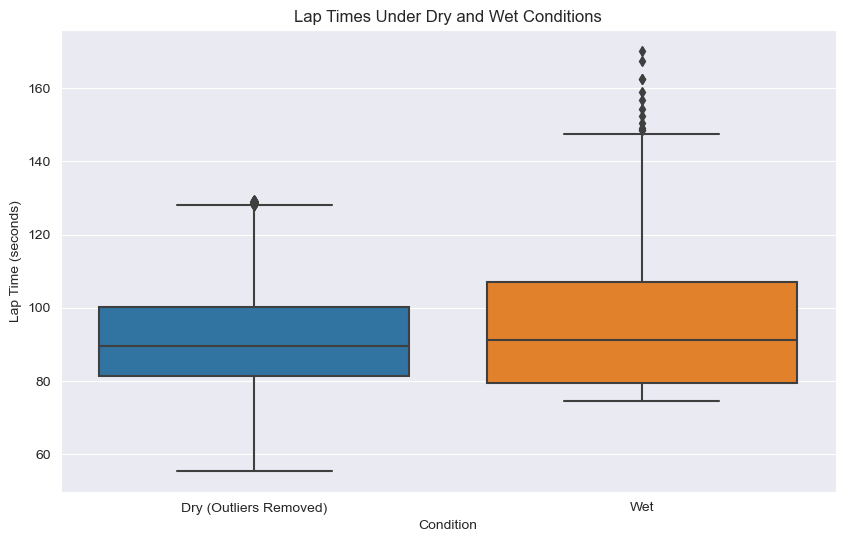

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_dry_filtered and df_wet are already defined and contain 'LapTime' along with a column identifying the condition
# If these DataFrames do not have a 'Condition' column, you will add it as follows:

df_dry_filtered['Condition'] = 'Dry (Outliers Removed)'
df_wet['Condition'] = 'Wet'

# Combine dry and wet DataFrame for visualization
combined_df = pd.concat([df_dry_filtered, df_wet], ignore_index=True)

# EDA - Visualization: Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Condition', y='LapTime', data=combined_df)

# Set y-axis limits to focus on a narrower range if needed
# plt.ylim(60, 85)  # Adjust these values based on your specific data range, or remove if not needed

plt.title('Lap Times Under Dry and Wet Conditions')
plt.xlabel('Condition')
plt.ylabel('Lap Time (seconds)')
plt.show()


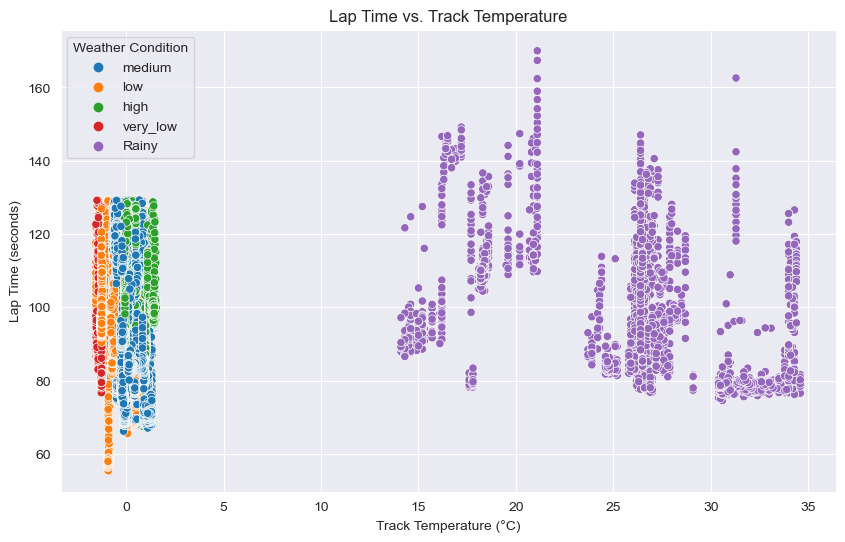

In [43]:
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TrackTemp', y='LapTime', hue='Original_Weather_Category', data=df_combined)
plt.title('Lap Time vs. Track Temperature')
plt.xlabel('Track Temperature (°C)')
plt.ylabel('Lap Time (seconds)')
plt.legend(title='Weather Condition')
plt.show()


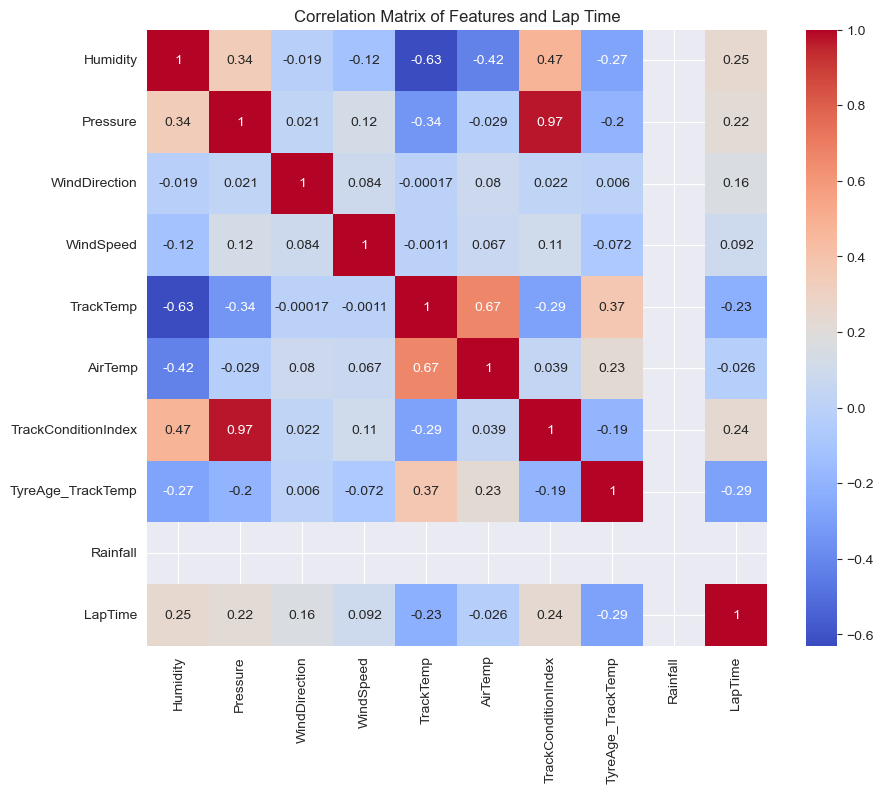

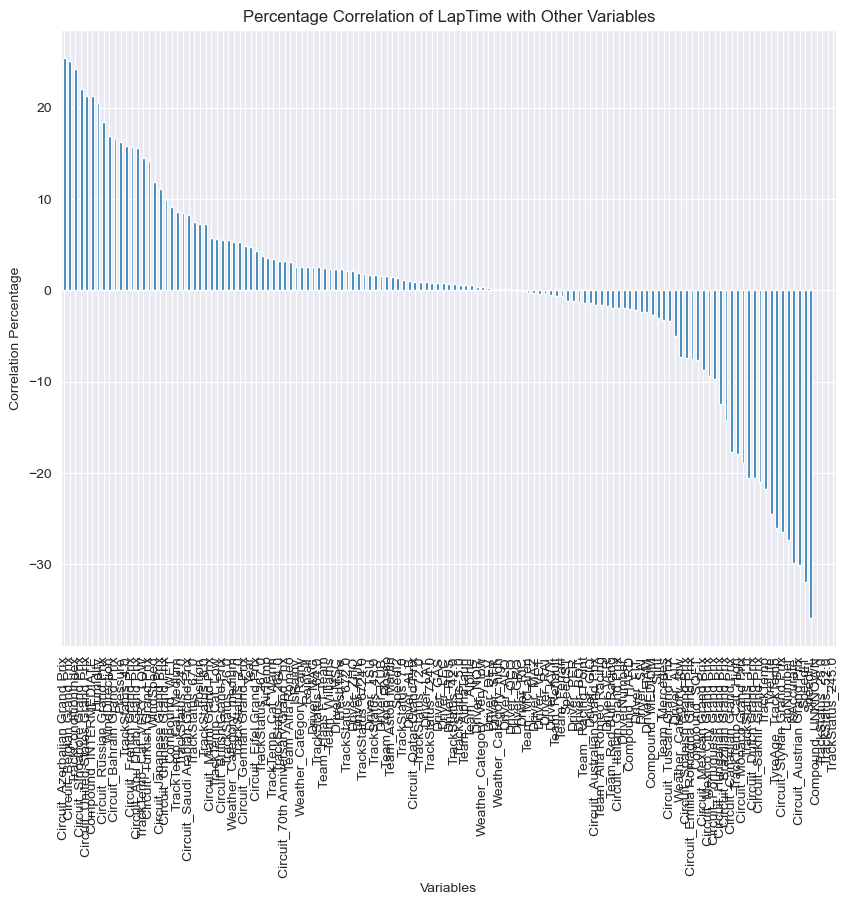

In [44]:
# Correlation Matrix
corr_matrix = df_dry_filtered[numeric_features + ['LapTime']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features and Lap Time')
plt.show()

# Optionally, visualize the correlations in descending order
plt.figure(figsize=(10, 8))
laptime_correlations_sorted.plot(kind='bar')
plt.title('Percentage Correlation of LapTime with Other Variables')
plt.ylabel('Correlation Percentage')
plt.xlabel('Variables')
plt.grid(True)
plt.show()


TrackConditionIndex: 24.29%
Humidity: 20.55%
WindDirection: 16.87%
Pressure: 16.23%
WindSpeed: 11.85%
AirTemp: 3.57%
Rainfall: 2.59%
TrackTemp: -21.79%
TyreAge_TrackTemp: -26.02%


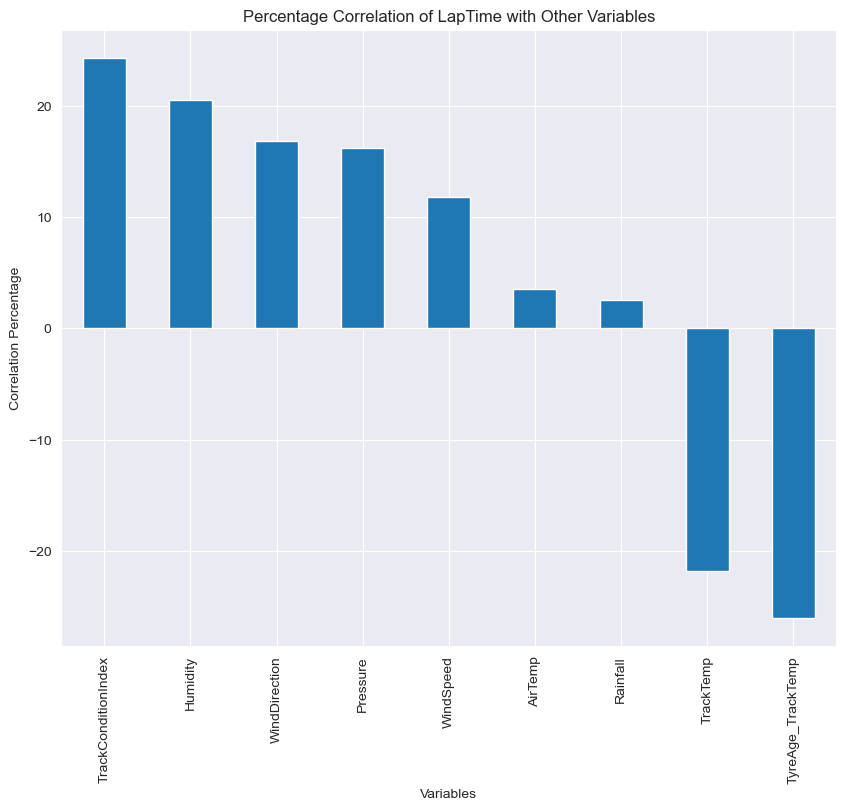

In [45]:
import pandas as pd
import matplotlib.pyplot as plt



correlation_matrix= df_combined[numeric_features + ['LapTime']].corr(method='spearman')

# Focus on 'LapTime' correlations
laptime_correlations = correlation_matrix['LapTime'].drop('LapTime')  # drop self-correlation

# Convert correlations to percentage and sort in descending order
laptime_correlations_percentage = laptime_correlations * 100
laptime_correlations_sorted = laptime_correlations_percentage.sort_values(ascending=False)

# Convert to list and format the output
laptime_correlations_list = [(f"{index}: {value:.2f}%") for index, value in laptime_correlations_sorted.items()]

# Print the formatted list
for item in laptime_correlations_list:
    print(item)

# Optionally, visualize the correlations in descending order
plt.figure(figsize=(10, 8))
laptime_correlations_sorted.plot(kind='bar')
plt.title('Percentage Correlation of LapTime with Other Variables')
plt.ylabel('Correlation Percentage')
plt.xlabel('Variables')
plt.grid(True)
plt.show()


/var/folders/_5/533f3cq93vq25vl2f3txpkb40000gn/T/ipykernel_10744/3084399156.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_combined.corr(method='spearman')


Circuit_Azerbaijan Grand Prix: 25.42%
Circuit_Belgian Grand Prix: 25.14%
TrackConditionIndex: 24.29%
Circuit_Singapore Grand Prix: 22.07%
Circuit_United States Grand Prix: 21.29%
Compound_INTERMEDIATE: 21.28%
Humidity: 20.55%
Circuit_Russian Grand Prix: 18.49%
WindDirection: 16.87%
Circuit_Bahrain Grand Prix: 16.65%
Pressure: 16.23%
TrackStatus_4.0: 15.84%
Circuit_French Grand Prix: 15.68%
Circuit_Abu Dhabi Grand Prix: 15.59%
TrackTemp_Cat_VERY_LOW: 14.46%
Circuit_Turkish Grand Prix: 14.16%
WindSpeed: 11.85%
Circuit_Japanese Grand Prix: 11.12%
Circuit_Chinese Grand Prix: 9.94%
Compound_WET: 9.13%
TrackTemp_Cat_Medium: 8.62%
TrackStatus_24.0: 8.47%
Circuit_Saudi Arabian Grand Prix: 8.23%
TrackStatus_67.0: 7.52%
Position: 7.27%
TrackStatus_6.0: 7.26%
Circuit_Miami Grand Prix: 5.73%
TrackTemp_Cat_Low: 5.68%
Circuit_British Grand Prix: 5.56%
TrackStatus_26.0: 5.51%
Weather_Category_medium: 5.32%
TrackStatus_2.0: 5.30%
Circuit_German Grand Prix: 4.83%
Year: 4.77%
Circuit_Eifel Grand Prix: 4

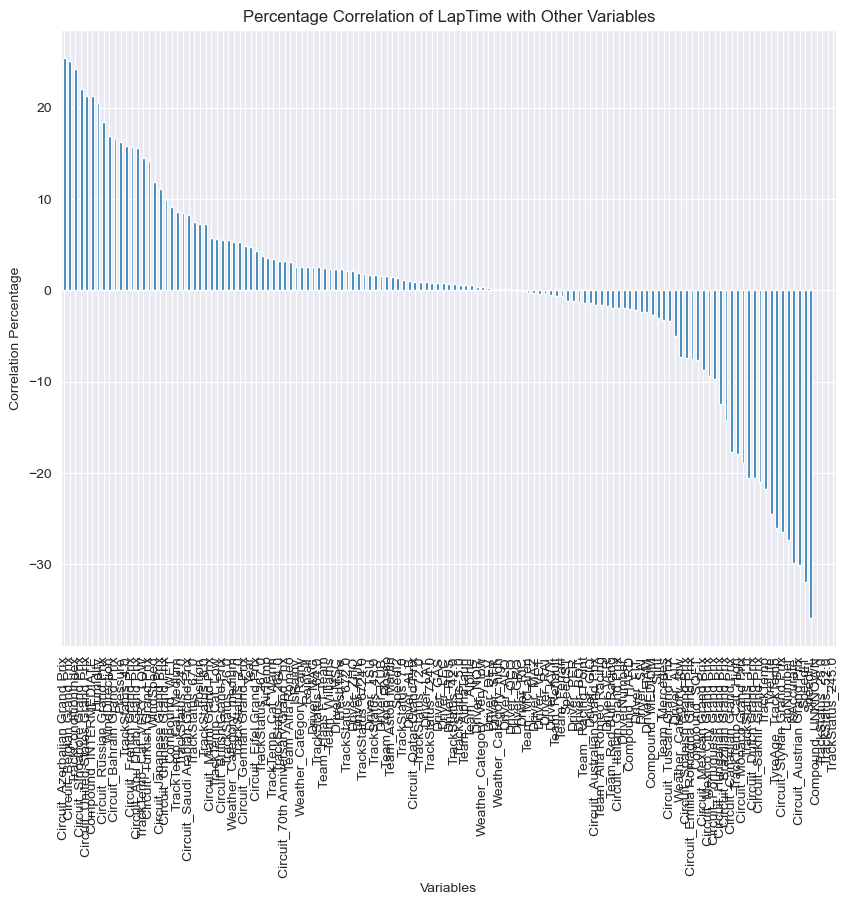

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate Spearman correlation matrix for df_combined
correlation_matrix = df_combined.corr(method='spearman')

# Focus on 'LapTime' correlations
laptime_correlations = correlation_matrix['LapTime'].drop('LapTime')  # drop self-correlation

# Convert correlations to percentage and sort in descending order
laptime_correlations_percentage = laptime_correlations * 100
laptime_correlations_sorted = laptime_correlations_percentage.sort_values(ascending=False)

# Convert to list and format the output
laptime_correlations_list = [(f"{index}: {value:.2f}%") for index, value in laptime_correlations_sorted.items()]

# Print the formatted list
for item in laptime_correlations_list:
    print(item)

# Optionally, visualize the correlations in descending order
plt.figure(figsize=(10, 8))
laptime_correlations_sorted.plot(kind='bar')
plt.title('Percentage Correlation of LapTime with Other Variables')
plt.ylabel('Correlation Percentage')
plt.xlabel('Variables')
plt.grid(True)
plt.show()


In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor



df_combined = df_combined.drop(['Original_Driver', 'Original_Circuit','Original_Weather_Category','Original_TrackTemp_Cat',], axis= 1)

# Separate features and target
X = df_combined.drop(['LapTime'], axis=1)
y = df_combined['LapTime']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training with XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
predictions = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Baseline RMSE for Dry_filtered df: {rmse}")

########

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the model
xgb = XGBRegressor(random_state=42)

# Set up the hyperparameters to test in GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# Custom scorer for RMSE
neg_rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Setup GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=kf,
                           scoring={'RMSE': neg_rmse_scorer, 'MAE': 'neg_mean_absolute_error', 'R2': 'r2'},
                           refit='RMSE',n_jobs=-1)
grid_search.fit(X, y)  # Make sure to fit on scaled X to maintain consistency

# Get the best model and print results
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_rmse = -grid_search.cv_results_['mean_test_RMSE'][grid_search.best_index_]
best_mae = -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_]
best_r2 = grid_search.cv_results_['mean_test_R2'][grid_search.best_index_]

print("Best model parameters:", best_params)
print(f"Best CV RMSE: {best_rmse:.3f}")
print(f"Best CV MAE: {best_mae:.3f}")
print(f"Best CV R²: {best_r2:.3f}")


XGBoostError: [19:52:23] /Users/runner/work/xgboost/xgboost/src/data/data.cc:507: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000017d168994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000017d225c9c xgboost::MetaInfo::SetInfoFromHost(xgboost::Context const&, xgboost::StringView, xgboost::Json) + 3452
  [bt] (2) 3   libxgboost.dylib                    0x000000017d224dc4 xgboost::MetaInfo::SetInfo(xgboost::Context const&, xgboost::StringView, xgboost::StringView) + 164
  [bt] (3) 4   libxgboost.dylib                    0x000000017d17f688 XGDMatrixSetInfoFromInterface + 224
  [bt] (4) 5   libffi.8.dylib                      0x000000010394804c ffi_call_SYSV + 76
  [bt] (5) 6   libffi.8.dylib                      0x0000000103945834 ffi_call_int + 1404
  [bt] (6) 7   _ctypes.cpython-311-darwin.so       0x0000000103a08140 _ctypes_callproc + 752
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103a024a4 PyCFuncPtr_call + 228
  [bt] (8) 9   python3.11                          0x000000010311653c _PyEval_EvalFrameDefault + 195268



In [ ]:
# Scatter plot for AirTemp vs. LapTime
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AirTemp', y='LapTime', data=df_combined)
plt.title('Air Temperature vs. Lap Time')
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Lap Time (seconds)')
plt.grid(True)
plt.show()

# Scatter plot for TrackTemp vs. LapTime
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TrackTemp', y='LapTime', data=df_combined)
plt.title('Track Temperature vs. Lap Time')
plt.xlabel('Track Temperature (°C)')
plt.ylabel('Lap Time (seconds)')
plt.grid(True)
plt.show()

# If you have categorical data related to weather like 'Rainfall', you can look at its effect too
sns.boxplot(x='Rainfall', y='LapTime', data=df_combined)
plt.title('Effect of Rainfall on Lap Times')
plt.xlabel('Rainfall (0 = No Rain, 1 = Rain)')
plt.ylabel('Lap Time (seconds)')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TrackTemp', y='LapTime', data=df_dry_filtered)
plt.title('Scatter Plot of Track Temperature vs. Lap Time')
plt.xlabel('Track Temperature')
plt.ylabel('Lap Time (seconds)')
plt.show()
